In [1]:
!pip install konlpy
!pip install mecab-python
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mecab-ko is already installed
mecab-ko-dic is already installed
mecab-python is already installed
Done.


In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Mecab
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from google.colab import drive
drive.mount('/content/drive')

%config InlineBackend.figure_format = 'retina'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
DATA_PATH = '/content/drive/MyDrive/06. 공유파일 집합폴더/00006_AIVLE School_5반 16조/2주차_데이터 분석/감정분석/data'
train = pd.read_excel(DATA_PATH+'/Re_Edited_Training_Dataset.xlsx')
train.dropna(inplace=True)
test = pd.read_excel(DATA_PATH+'/Re_Edited_Validation_Dataset.xlsx')
test.dropna(inplace=True)

In [4]:
train['감정'].value_counts()

중립    38984
부정    38102
긍정    11123
Name: 감정, dtype: int64

In [6]:
train['문장'] = train['문장'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test['문장'] = test['문장'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

stopwords = open(DATA_PATH+'/stopword.txt').read().split(', ')
mecab = Mecab()

X_train = []
for sentence in tqdm(train['문장']):
    tokenized_sentence = mecab.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

X_test = []
for sentence in tqdm(test['문장']):
    tokenized_sentence = mecab.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

<ipython-input-6-63f3d809dce2>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train['문장'] = train['문장'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
<ipython-input-6-63f3d809dce2>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test['문장'] = test['문장'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
100%|██████████| 22053/22053 [00:02<00:00, 8672.81it/s]


단어 집합(vocabulary)의 크기 : 28570
등장 빈도가 2번 이하인 희귀 단어의 수: 16040
단어 집합에서 희귀 단어의 비율: 56.14280714035702
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.391597917170371


단어 집합의 크기 : 12531


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


86023
86023
문장의 최대 길이 : 100
문장의 평균 길이 : 9.620764214221778


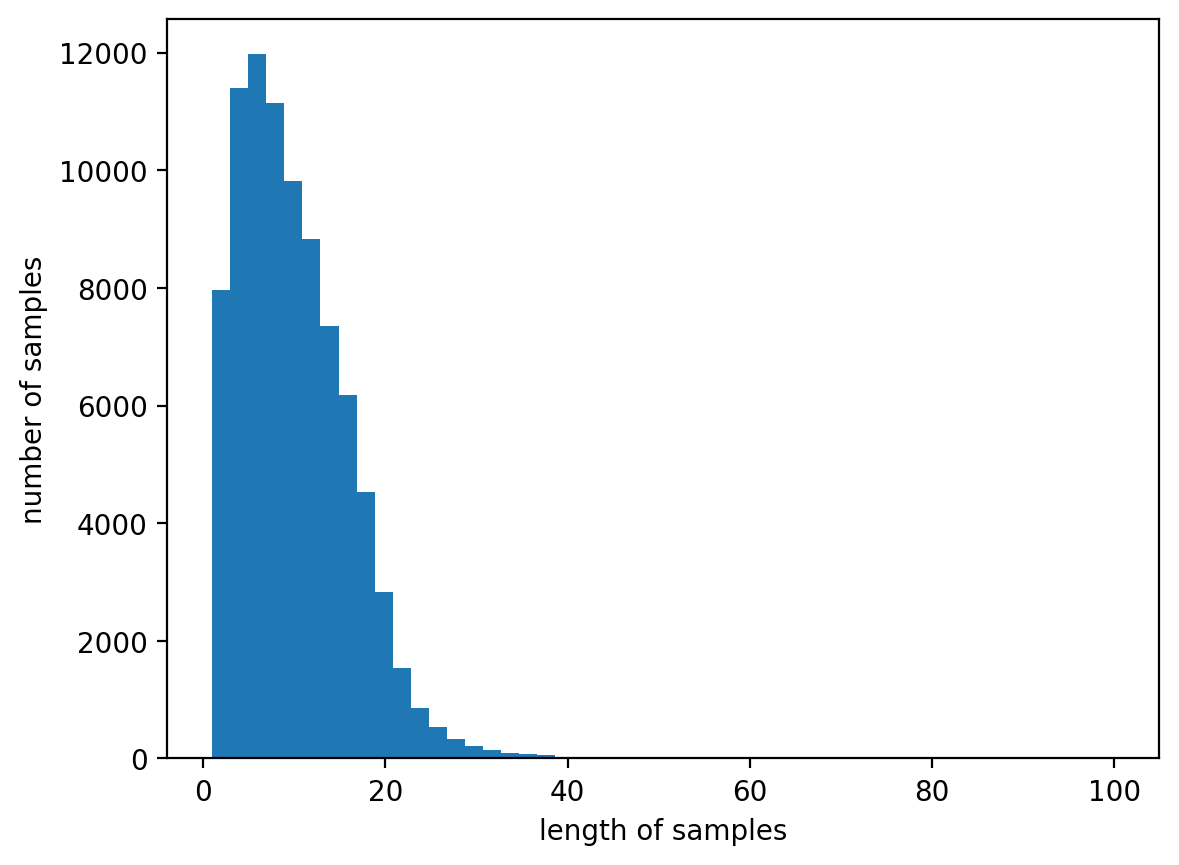

전체 샘플 중 길이가 30 이하인 샘플의 비율: 99.37226090696673


In [7]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

le = LabelEncoder()
le = le.fit(train['감정'])
train['감정'] = le.transform(train['감정'])
test['감정'] = le.transform(test['감정'])

import pickle 
with open(DATA_PATH + '/labelencoder_230607.pickle','wb') as fw:
    pickle.dump(le, fw)

y_train = np.array(train['감정'])
y_test = np.array(test['감정'])

drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

print('문장의 최대 길이 :',max(len(review) for review in X_train))
print('문장의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

max_len = 30
below_threshold_len(max_len, X_train)

In [8]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [9]:
y_test.shape

(22053, 3)

In [12]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(3, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint(DATA_PATH + '/best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 100)         1253100   
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 1,370,735
Trainable params: 1,370,735
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = model.fit(X_train, y_train, epochs=50, callbacks=[es, mc], batch_size=128, validation_split=0.2)

Epoch 1/50
538/538 [==============================] - ETA: 0s - loss: 0.6240 - acc: 0.7345
Epoch 1: val_acc improved from -inf to 0.77995, saving model to /content/drive/MyDrive/06. 공유파일 집합폴더/00006_AIVLE School_5반 16조/2주차_데이터 분석/감정분석/data/best_model.h5
538/538 [==============================] - 78s 140ms/step - loss: 0.6240 - acc: 0.7345 - val_loss: 0.5323 - val_acc: 0.7799
Epoch 2/50
538/538 [==============================] - ETA: 0s - loss: 0.4686 - acc: 0.8107
Epoch 2: val_acc improved from 0.77995 to 0.78088, saving model to /content/drive/MyDrive/06. 공유파일 집합폴더/00006_AIVLE School_5반 16조/2주차_데이터 분석/감정분석/data/best_model.h5
538/538 [==============================] - 75s 139ms/step - loss: 0.4686 - acc: 0.8107 - val_loss: 0.5322 - val_acc: 0.7809
Epoch 3/50
538/538 [==============================] - ETA: 0s - loss: 0.4109 - acc: 0.8374
Epoch 3: val_acc did not improve from 0.78088
538/538 [==============================]

In [14]:
import pickle 
with open(DATA_PATH + '/model_230608.pickle','wb') as fw:
  pickle.dump(model, fw)

with open(DATA_PATH + '/Tokenizer_230608.pickle', 'wb') as fw:
  pickle.dump(tokenizer, fw)

with open(DATA_PATH + '/labelencoder_230608.pickle','wb') as fw:
  pickle.dump(le, fw)

with open(DATA_PATH + '/Mecab_230608.pickle','wb') as fw:
  pickle.dump(mecab, fw)

In [15]:
import pickle 
with open(DATA_PATH + '/model_230608.pickle', 'rb') as f: 
    loaded_model = pickle.load(f)

In [16]:
y_pred = loaded_model.predict(X_test)
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)

690/690 [==============================] - 14s 19ms/step


In [17]:
print(confusion_matrix(y_test, y_pred), classification_report(y_test, y_pred), sep="\n\n******\n\n")

[[1785  455  568]
 [ 360 7132 2121]
 [ 307 1463 7862]]

******

              precision    recall  f1-score   support

           0       0.73      0.64      0.68      2808
           1       0.79      0.74      0.76      9613
           2       0.75      0.82      0.78      9632

    accuracy                           0.76     22053
   macro avg       0.75      0.73      0.74     22053
weighted avg       0.76      0.76      0.76     22053



In [ ]:
def sentiment_predict(new_sentence):
  mecab = Mecab()
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  y_pred=np.argmax(y_pred, axis=1)
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

sentiment_predict(input())

하... 자살 마렵다...
1/1 [==============================] - 1s 724ms/step


TypeError: ignored